<a href="https://colab.research.google.com/github/sn0rkmaiden/Methods-of-solving-TSP/blob/main/PSO_in_TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[Imports 💻](#updateTitle=true&folderId=13fkGtWyf0sMKWQkTCoyshhW236L9icob&scrollTo=D_KkGDk8dH0x&uniqifier=1)

>[Load ATSP problems 📂](#updateTitle=true&folderId=13fkGtWyf0sMKWQkTCoyshhW236L9icob&scrollTo=MHu5Ew7dy0Y5&uniqifier=1)

>[Mathematical model in general case 📓](#updateTitle=true&folderId=13fkGtWyf0sMKWQkTCoyshhW236L9icob&scrollTo=Z5XNukLNeEtx&uniqifier=1)

>[Algorithm 💽](#updateTitle=true&folderId=13fkGtWyf0sMKWQkTCoyshhW236L9icob&scrollTo=Wt_eRAIjrfNN&uniqifier=1)

>[Evaluation ⏲](#updateTitle=true&folderId=13fkGtWyf0sMKWQkTCoyshhW236L9icob&scrollTo=T1vxwRFEMt1X&uniqifier=1)

>[PSO Analysis 📊](#updateTitle=true&folderId=13fkGtWyf0sMKWQkTCoyshhW236L9icob&scrollTo=kZOgLmOCPrQD&uniqifier=1)

>[Genetic Algorithm 🌍](#updateTitle=true&folderId=13fkGtWyf0sMKWQkTCoyshhW236L9icob&scrollTo=JXu73UYIgrKM&uniqifier=1)

>[Ant Colony Optimization Algorithm 🐜](#updateTitle=true&folderId=13fkGtWyf0sMKWQkTCoyshhW236L9icob&scrollTo=3yiMYM_PvrVz&uniqifier=1)

>[ACO Analysis 📈](#updateTitle=true&folderId=13fkGtWyf0sMKWQkTCoyshhW236L9icob&scrollTo=aZwn-Q6A_BgP&uniqifier=1)



# Imports 💻

In [3]:
import numpy as np
import pandas as pd
import math
import os
from time import sleep
from IPython import display
import time
import json
import random
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
!pip -q install tsplib95
from tsplib95.loaders import load_problem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.27.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
nx-cugraph-cu12 24.10.0 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.


# Load ATSP problems 📂

In [11]:
!wget -q "http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/XML-TSPLIB/instances/sourcesAsymmetricTSP.zip"

In [12]:
!unzip -q "/content/sourcesAsymmetricTSP.zip"

In [13]:
!git clone "https://github.com/pdrozdowski/TSPLib.Net.git"

Cloning into 'TSPLib.Net'...
remote: Enumerating objects: 1047, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1047 (delta 0), reused 0 (delta 0), pack-reused 1046 (from 1)
Receiving objects: 100% (1047/1047), 3.47 MiB | 16.01 MiB/s, done.
Resolving deltas: 100% (613/613), done.


In [14]:
# @title
def read_atsplib(filename):
     "basic function for reading a ATSP problem on the TSPLIB format"
     "NOTE: only works for explicit matrices"

     if filename[-3:] == ".gz":
         f = gzip.open(filename, 'r')
         data = f.readlines()
     else:
         f = open(filename, 'r')
         data = f.readlines()

     for line in data:
         if line.find("DIMENSION") >= 0:
             n = int(line.split()[1])
             break
     else:
         raise IOError("'DIMENSION' keyword not found in file '%s'" % filename)

     for line in data:
         if line.find("EDGE_WEIGHT_TYPE") >= 0:
             if line.split()[1] == "EXPLICIT":
                 break
     else:
         raise IOError("'EDGE_WEIGHT_TYPE' is not 'EXPLICIT' in file '%s'" % filename)

     for k, line in enumerate(data):
         if line.find("EDGE_WEIGHT_SECTION") >= 0:
             break
     else:
         raise IOError("'EDGE_WEIGHT_SECTION' not found in file '%s'" % filename)

     c = {}
     # flatten list of distances
     dist = []
     for line in data[k + 1:]:
         if line.find("EOF") >= 0:
             break
         for val in line.split():
             dist.append(int(val))

     k = 0
     for i in range(n):
         for j in range(n):
             c[i + 1, j + 1] = dist[k]
             k += 1

     return n, c

In [15]:
sols = {}
with open("/content/TSPLib.Net/TSPLIB95/atsp/bestSolutions.txt") as f:
    for line in f:
       (key, val) = line.split()
       sols[key[:-1]] = int(val)

In [16]:
tsplib_dir = './sourcesAsymmetricTSP'
files = os.listdir(tsplib_dir)
problem_files = [file for file in files if file.endswith('.atsp')]

# Mathematical model in general case 📓

$$ X^{t+1}_i = X^{t}_i + V^{t+1}_i $$

$$ V^{t+1}_i = w \cdot V^{t}_i + c_1r_1(P^{t}_i - X^{t}_i) + c_2r_2(G^{t} - X^{t}_i)$$

$$ V^{t+1}_i = inertia + individual \: component + social \: component $$

$$ G^{t} - best \: position \: found \: by \: the \: entire \: swarm $$

$$ P^{t}_i - individual \: best \: position $$

$$ w - exploration \: vs \: exploitation \: parameter $$

Stopping criteria:


*   Identify when error is small enought to stop
*   Stop if error is no longer decreasing or decreasing too slowly
*   Limit maximum time
*   All particles reached the same value



**Ideas to solve local minima problem**:

*   Make a forbidden boundary around detected local optimum and reinitialize positions and velocities of particles whenever they cross it
*   When patricles have reached the same value assign random positions to half of them and check if they converge on different value



# Algorithm 💽

First version of PSO. **Does not include any methods to prevent being stuck in local minima.**

In [ ]:
class Particlev1:
    def __init__(self, route, dist_matr, cost=None):
        self.route = route
        self.dist_matr = dist_matr
        self.pbest = route # current individual best route
        self.current_cost = cost if cost else self.path_cost()
        self.pbest_cost = cost if cost else self.path_cost()
        self.velocity = [] # indicies of the cities that should be swapped to be closer to optimal route

    def clear_velocity(self):
        self.velocity.clear()

    def update_costs_and_pbest(self):
      self.current_cost = self.path_cost()
      if self.current_cost < self.pbest_cost:
          self.pbest = self.route
          self.pbest_cost = self.current_cost

    def path_cost(self):
      return sum([self.dist_matr[city][self.route[index - 1]] for index, city in enumerate(self.route)])

In [ ]:
class PSOv1:

    def __init__(self, iterations, population_size, dist_matr, gbest_probability=1.0, pbest_probability=1.0, num_cities=None):
        self.num_cities = num_cities
        self.gbest = None
        self.dist_matr = dist_matr
        self.gcost_iter = [] # how gbest changes
        self.iterations = iterations
        self.population_size = population_size
        self.particles = []
        self.gbest_probability = gbest_probability
        self.pbest_probability = pbest_probability
        self.last_iteration = 0
        self.initial_cost = 0

        solutions = self.initial_population()
        # each particle goes randomly at first
        self.particles = [Particlev1(route=solution, dist_matr=dist_matr) for solution in solutions]

    def random_route(self):
        return random.sample([i for i in range(self.num_cities)], self.num_cities)

    def initial_population(self):
        random_population = [self.random_route() for _ in range(self.population_size - 1)]
        # use random route in half of the runs
        # if random.random() < 0.5:
        greedy_population = [self.greedy_route(0)]
        return [*random_population, *greedy_population]
        # else:
          # return [*random_population]

    def greedy_route(self, start_index):
        unvisited = [i for i in range(self.num_cities)]
        del unvisited[start_index]
        route = [[i for i in range(self.num_cities)][start_index]]
        while len(unvisited):
            index, nearest_city = min(enumerate(unvisited), key=lambda item: adj[item[1]][route[-1]])
            route.append(nearest_city)
            del unvisited[index]
        return route

    def run(self):
        # gbest equals to the particle object with minimum best invidual path cost
        self.gbest = min(self.particles, key=lambda p: p.pbest_cost)
        repeats = 0
        print(f"initial cost is {self.gbest.pbest_cost}")
        self.initial_cost = self.gbest.pbest_cost
        for t in range(self.iterations):

            if t > 0 and self.gcost_iter[-1] == self.gbest.pbest_cost:
              repeats += 1

            # stop if value doesn't change or changes too slowly
            if t > 0 and repeats > self.iterations * 0.75:
              print('Repeats!')
              self.last_iteration = t + 1
              break

            # stop if all particles have reached the same value
            if all([p.pbest_cost == self.gbest.pbest_cost for p in self.particles]):
              self.last_iteration = t + 1
              print('Patricles have reached same value or value repeats for too long!')
              break

            prev_gbest_cost = self.gbest.pbest_cost
            self.gbest = min(self.particles, key=lambda p: p.pbest_cost)
            self.gcost_iter.append(self.gbest.pbest_cost)

            if self.gbest.pbest_cost != prev_gbest_cost:
              repeats = 0

            for particle in self.particles:
                particle.clear_velocity()
                temp_velocity = []
                gbest = self.gbest.pbest[:] # best global route so far
                new_route = particle.route[:] # current route of the particle (not optimum)

                # find differences between current particle route and it's current individual path
                # would change new_route to be exactly like particle.pbest route if exclude probabilities
                for i in range(self.num_cities):
                    if new_route[i] != particle.pbest[i]:
                        j = particle.pbest.index(new_route[i]) # city new_route[i] is not in correct place, it's place in optimal path is j
                        swap = (i, j, self.pbest_probability)
                        temp_velocity.append(swap)
                        new_route[swap[0]], new_route[swap[1]] = \
                            new_route[swap[1]], new_route[swap[0]]

                # same but with current global best path
                for i in range(self.num_cities):
                    if new_route[i] != gbest[i]:
                        swap = (i, gbest.index(new_route[i]), self.gbest_probability)
                        temp_velocity.append(swap)
                        gbest[swap[0]], gbest[swap[1]] = gbest[swap[1]], gbest[swap[0]]

                particle.velocity = temp_velocity

                # making particle lean a bit towards it's current optimal route and a bit towards current global optimal route
                for swap in temp_velocity:
                    if random.random() <= swap[2]:
                        new_route[swap[0]], new_route[swap[1]] = \
                            new_route[swap[1]], new_route[swap[0]]

                # update individual best route and individual best cost for each particle
                particle.route = new_route
                particle.update_costs_and_pbest()
        if self.last_iteration == 0:
          self.last_iteration = self.iterations

Improved version of PSO. **Attempts to escape local minima once.**

In [17]:
class Particlev2:
    def __init__(self, route, dist_matr, cost=None):
        self.route = route
        self.dist_matr = dist_matr
        self.pbest = route # current individual best route
        self.current_cost = cost if cost else self.path_cost()
        self.pbest_cost = cost if cost else self.path_cost()
        self.velocity = [] # indicies of the cities that should be swapped to be closer to optimal route

    def clear_velocity(self):
        self.velocity.clear()

    def update_costs_and_pbest(self, local_minima):
        if self.route in [el[0] for el in local_minima]:
          self.current_cost = np.inf
        else:
          self.current_cost = self.path_cost()
          if self.current_cost < self.pbest_cost:
              self.pbest = self.route
              self.pbest_cost = self.current_cost

    def path_cost(self):
      return sum([self.dist_matr[city][self.route[index - 1]] for index, city in enumerate(self.route)])

In [18]:
class PSOv2:

    def __init__(self, iterations, population_size, dist_matr, gbest_probability=1.0, pbest_probability=1.0, num_cities=None):
        self.num_cities = num_cities
        self.gbest = None
        self.dist_matr = dist_matr
        self.gcost_iter = [] # how gbest changes
        self.iterations = iterations
        self.population_size = population_size
        self.particles = []
        self.gbest_probability = gbest_probability
        self.pbest_probability = pbest_probability
        self.last_iteration = 0
        self.initial_cost = 0
        self.local_minima = []
        self.all_repeats = []

        solutions = self.initial_population()
        # each particle goes randomly at first
        self.particles = [Particlev2(route=solution, dist_matr=dist_matr) for solution in solutions]

    def random_route(self):
        return random.sample([i for i in range(self.num_cities)], self.num_cities)

    def initial_population(self):
        random_population = [self.random_route() for _ in range(self.population_size - 1)]
        # use random route in half of the runs
        # if random.random() < 0.5:
        greedy_population = [self.greedy_route(0)]
        return [*random_population, *greedy_population]
        # else:
          # return [*random_population]

    def greedy_route(self, start_index):
        unvisited = [i for i in range(self.num_cities)]
        del unvisited[start_index]
        route = [[i for i in range(self.num_cities)][start_index]]
        while len(unvisited):
            index, nearest_city = min(enumerate(unvisited), key=lambda item: adj[item[1]][route[-1]])
            route.append(nearest_city)
            del unvisited[index]
        return route

    def run(self):
        # gbest equals to the particle object with minimum best invidual path cost
        self.gbest = min(self.particles, key=lambda p: p.pbest_cost)
        repeats = 0
        print(f"initial cost is {self.gbest.pbest_cost}")
        self.initial_cost = self.gbest.pbest_cost
        tried_escape=False
        for t in range(self.iterations):
            self.all_repeats.append(repeats)

            if t > 0 and self.gcost_iter[-1] == self.gbest.pbest_cost:
              repeats += 1
            # else:
              # repeats = 0

            # stop if value doesn't change or changes too slowly
            # if t > 0 and repeats > self.iterations * 0.75:
            #   print('Repeats!')
            #   self.last_iteration = t + 1
            #   if self.local_minima:
            #     self.gbest.pbest_cost = min(self.gbest.pbest_cost, min([el[1] for el in self.local_minima]))
            #   break

            # stop if all particles have reached the same value
            if t > 0 and (all([p.pbest_cost == self.gbest.pbest_cost for p in self.particles]) or repeats > self.iterations * 0.25):
              # assume it might be local minima
              if tried_escape:
                self.last_iteration = t + 1
                print('Patricles have reached same value or value repeats for too long!')
                self.gbest.pbest_cost = min(self.gbest.pbest_cost, min([el[1] for el in self.local_minima]))
                break
              else:
                print(f't={t} trying to escape local minima - {self.gbest.pbest_cost}')
                self.local_minima.append([self.gbest, self.gbest.pbest_cost])
                solutions = self.initial_population()
                self.particles = [Particlev2(route=solution, dist_matr=self.dist_matr) for solution in solutions]
                self.gbest = min(self.particles, key=lambda p: p.pbest_cost)
                tried_escape=True
                repeats = 0
                continue

            prev_gbest_cost = self.gbest.pbest_cost
            self.gbest = min(self.particles, key=lambda p: p.pbest_cost)
            self.gcost_iter.append(self.gbest.pbest_cost)

            if self.gbest.pbest_cost != prev_gbest_cost:
              repeats = 0

            for particle in self.particles:
                particle.clear_velocity()
                temp_velocity = []
                gbest = self.gbest.pbest[:] # best global route so far
                new_route = particle.route[:] # current route of the particle (not optimum)

                # find differences between current particle route and it's current individual path
                # would change new_route to be exactly like particle.pbest route if exclude probabilities
                for i in range(self.num_cities):
                    if new_route[i] != particle.pbest[i]:
                        j = particle.pbest.index(new_route[i]) # city new_route[i] is not in correct place, it's place in optimal path is j
                        swap = (i, j, self.pbest_probability)
                        temp_velocity.append(swap)
                        new_route[swap[0]], new_route[swap[1]] = \
                            new_route[swap[1]], new_route[swap[0]]

                # same but with current global best path
                for i in range(self.num_cities):
                    if new_route[i] != gbest[i]:
                        swap = (i, gbest.index(new_route[i]), self.gbest_probability)
                        temp_velocity.append(swap)
                        gbest[swap[0]], gbest[swap[1]] = gbest[swap[1]], gbest[swap[0]]

                particle.velocity = temp_velocity

                # making particle lean a bit towards it's current optimal route and a bit towards current global optimal route
                for swap in temp_velocity:
                    if random.random() <= swap[2]:
                        new_route[swap[0]], new_route[swap[1]] = \
                            new_route[swap[1]], new_route[swap[0]]

                # update individual best route and individual best cost for each particle

                particle.route = new_route
                particle.update_costs_and_pbest(self.local_minima)

        if self.last_iteration == 0:
          self.last_iteration = self.iterations
          if self.local_minima:
            self.gbest.pbest_cost = min(self.gbest.pbest_cost, min([el[1] for el in self.local_minima]))

In [150]:
w = 'ftv33.atsp'
n, c = read_atsplib(f'/content/sourcesAsymmetricTSP/{w}')
print(n, c)

34 {(1, 1): 100000000, (1, 2): 26, (1, 3): 82, (1, 4): 65, (1, 5): 100, (1, 6): 147, (1, 7): 134, (1, 8): 69, (1, 9): 117, (1, 10): 42, (1, 11): 89, (1, 12): 125, (1, 13): 38, (1, 14): 13, (1, 15): 38, (1, 16): 31, (1, 17): 22, (1, 18): 103, (1, 19): 143, (1, 20): 94, (1, 21): 104, (1, 22): 123, (1, 23): 98, (1, 24): 58, (1, 25): 38, (1, 26): 30, (1, 27): 67, (1, 28): 120, (1, 29): 149, (1, 30): 100, (1, 31): 93, (1, 32): 162, (1, 33): 62, (1, 34): 66, (2, 1): 66, (2, 2): 100000000, (2, 3): 56, (2, 4): 39, (2, 5): 109, (2, 6): 156, (2, 7): 140, (2, 8): 135, (2, 9): 183, (2, 10): 108, (2, 11): 155, (2, 12): 190, (2, 13): 104, (2, 14): 79, (2, 15): 104, (2, 16): 97, (2, 17): 88, (2, 18): 130, (2, 19): 176, (2, 20): 121, (2, 21): 131, (2, 22): 150, (2, 23): 125, (2, 24): 85, (2, 25): 65, (2, 26): 57, (2, 27): 94, (2, 28): 147, (2, 29): 160, (2, 30): 80, (2, 31): 67, (2, 32): 189, (2, 33): 128, (2, 34): 40, (3, 1): 43, (3, 2): 57, (3, 3): 100000000, (3, 4): 16, (3, 5): 53, (3, 6): 100, (3,

In [151]:
adj = np.zeros((n, n))
for pair, distance in c.items():
  adj[pair[0] - 1][pair[1] - 1] = int(distance)
adj = adj.astype(int)

Single run test 🏃

In [159]:
pso = PSOv2(iterations=3000, population_size=1000, dist_matr=adj, pbest_probability=0.8, gbest_probability=0.01, num_cities=n)

initial cost is 1525
t=1693 trying to escape local minima - 1433
time: 104.723s | true_cost: 1286 | cost: 1430 | last_iter: 3000 | gbest: [13, 12, 14, 15, 16, 0, 25, 29, 28, 27, 26, 22, 21, 20, 23, 24, 1, 3, 2, 33, 30, 5, 6, 4, 7, 32, 9, 8, 11, 17, 18, 31, 19, 10]


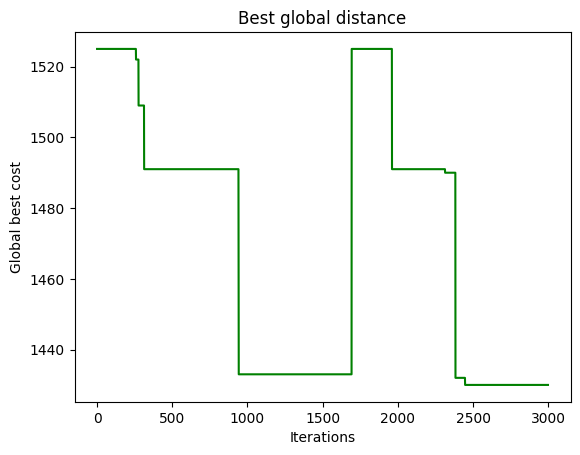

In [160]:
st_time = time.time()
pso.run()
ed_time = time.time()
print(f'time: {ed_time - st_time:.3f}s | true_cost: {sols[w.split(".")[0]]} | cost: {pso.gbest.pbest_cost} | last_iter: {pso.last_iteration} | gbest: {pso.gbest.pbest}')

plt.title('Best global distance')
plt.xlabel('Iterations')
plt.ylabel('Global best cost')
plt.plot(pso.gcost_iter, 'g')

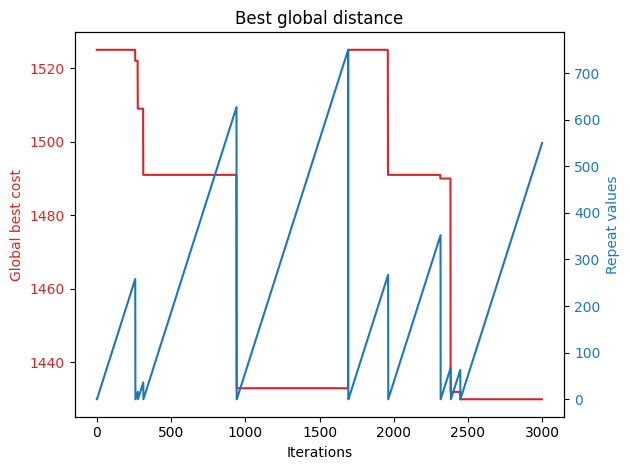

In [161]:
fig, ax1 = plt.subplots()
color = 'tab:red'

ax1.set_title('Best global distance')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Global best cost', color=color)
ax1.plot(pso.gcost_iter, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'

ax2.set_ylabel('Repeat values', color=color)
ax2.plot(pso.all_repeats, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

# Evaluation ⏲

In [17]:
# files to compare with branch and bound
# target_problem_files = ['br17.atsp', 'ftv33.atsp', 'ftv35.atsp', 'ftv38.atsp', 'ftv44.atsp', 'ftv47.atsp']

In [20]:
runs = {}
i = 0

# for p in problem_files:
p = "ftv33.atsp"
  # run if there is a true answer
if p.split('.')[0] in sols.keys():
  true_val = sols[p.split('.')[0]]
  # hyperparameter tuning
  # for pop_size in [400, 800, 1600]:
    # for iters in [1000, 1500]:
      # for pbest_prob in [0.7, 0.9]:
        # for g_best_prob in [0.01, 0.05, 0.1]:
  for _ in range(20):
    pop_size=300
    iters=1000
    pbest_prob=0.9
    g_best_prob=0.01
    # prepare data
    n, c = read_atsplib(f'/content/sourcesAsymmetricTSP/{p}')
    adj = np.zeros((n, n))
    for pair, distance in c.items():
      adj[pair[0] - 1][pair[1] - 1] = int(distance)
    adj = adj.astype(int)
    pso = PSOv2(iterations=iters, population_size=pop_size, dist_matr=adj, pbest_probability=pbest_prob, gbest_probability=g_best_prob, num_cities=n)
    start_time = time.time()
    pso.run()
    end_time = time.time()
    print(f'dim: {n} | pop_size: {pop_size} | iters: {iters} | time: {end_time - start_time:.3f}s | true_cost: {true_val} | cost: {pso.gbest.pbest_cost} last_iteration: {pso.last_iteration} | pbest: {pbest_prob} | gbest: {g_best_prob} | gbest: {pso.gbest.pbest}')
    runs[i] = {'dimension': n, 'pop_size': pop_size, 'true_cost': true_val, 'cost': pso.gbest.pbest_cost, 'num_iterations': iters, 'time': round(end_time - start_time, 3), 'pbest_prob': pbest_prob, 'gbest_prob': g_best_prob, 'last_iteration': pso.last_iteration, 'initial_cost': pso.initial_cost, 'error': (pso.gbest.pbest_cost - true_val), 'gcost_iter': pso.gcost_iter}
    i += 1

initial cost is 1525
t=251 trying to escape local minima - 1525
Patricles have reached same value or value repeats for too long!
dim: 34 | pop_size: 300 | iters: 1000 | time: 5.762s | true_cost: 1286 | cost: 1525 last_iteration: 503 | pbest: 0.9 | gbest: 0.01 | gbest: [0, 13, 12, 15, 14, 16, 25, 29, 28, 27, 26, 22, 20, 21, 23, 24, 1, 3, 2, 33, 30, 5, 6, 4, 7, 32, 9, 8, 10, 17, 18, 31, 19, 11]
initial cost is 1525
t=251 trying to escape local minima - 1525
Patricles have reached same value or value repeats for too long!
dim: 34 | pop_size: 300 | iters: 1000 | time: 7.449s | true_cost: 1286 | cost: 1525 last_iteration: 503 | pbest: 0.9 | gbest: 0.01 | gbest: [0, 13, 12, 15, 14, 16, 25, 29, 28, 27, 26, 22, 20, 21, 23, 24, 1, 3, 2, 33, 30, 5, 6, 4, 7, 32, 9, 8, 10, 17, 18, 31, 19, 11]
initial cost is 1525
t=251 trying to escape local minima - 1525
Patricles have reached same value or value repeats for too long!
dim: 34 | pop_size: 300 | iters: 1000 | time: 5.776s | true_cost: 1286 | cost: 

In [21]:
df = pd.DataFrame(runs).T

In [14]:
# worst_case = dict(zip(df['dimension'], df['initial_cost']))

In [22]:
filename = "33_fixed_parameters_whistory.csv"
df.to_csv(filename, index=False)

In [23]:
from google.colab import files
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# PSO Analysis 📊

In [24]:
# Branch and bound experiments
bb_exp = {
    0: {'dimension': 17, 'time': 4.08454704284668, 'num_iterations': 8547, 'last_iteration': 49},
    1: {'dimension': 34, 'time': 20.084980249404907, 'num_iterations': 30709, 'last_iteration': 21501},
    2: {'dimension': 36, 'time': 8.665074348449707, 'num_iterations': 10743, 'last_iteration': 2483},
    3: {'dimension': 39, 'time': 27.121103525161743, 'num_iterations': 40728, 'last_iteration': 33975},
    4: {'dimension': 45, 'time': 128.31369972229004, 'num_iterations': 180614, 'last_iteration': 77631},
    5:{'dimension': 48, 'time': 2430.343325853348, 'num_iterations': 3225488, 'last_iteration': 2769154},

    6:{'dimension': 17, 'time': 6.729508638381958, 'num_iterations': np.nan, 'last_iteration': np.nan},
    7:{'dimension': 34, 'time': 43.31771516799927, 'num_iterations': np.nan, 'last_iteration': np.nan},
    8:{'dimension': 36, 'time': 41.35138177871704, 'num_iterations': np.nan, 'last_iteration': np.nan},
    9:{'dimension': 39, 'time': 73.82156896591187, 'num_iterations': np.nan, 'last_iteration': np.nan},
    10:{'dimension': 45, 'time': 150.27879667282104, 'num_iterations': np.nan, 'last_iteration': np.nan},
    11:{'dimension': 48, 'time': 2710.4902646541595, 'num_iterations': np.nan, 'last_iteration': np.nan},

    12:{'dimension': 17, 'time': 3.71524977684021, 'num_iterations': np.nan, 'last_iteration': np.nan},
    13:{'dimension': 34, 'time': 16.20943784713745, 'num_iterations': np.nan, 'last_iteration': np.nan},
    14:{'dimension': 36, 'time': 7.388563632965088, 'num_iterations': np.nan, 'last_iteration': np.nan},
    15:{'dimension': 39, 'time': 25.22965693473816, 'num_iterations': np.nan, 'last_iteration': np.nan},
    16:{'dimension': 45, 'time': 125.98599290847778, 'num_iterations': np.nan, 'last_iteration': np.nan},
    17:{'dimension': 48, 'time': 2279.4400498867035, 'num_iterations': np.nan, 'last_iteration': np.nan}}
df_bb = pd.DataFrame(bb_exp).T

Text(0, 0.5, 'Time (s)')

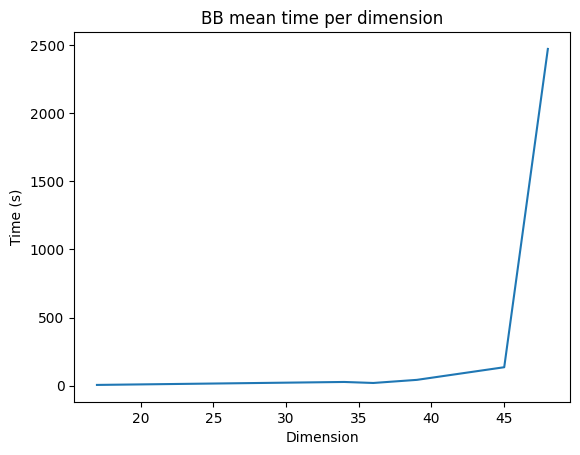

In [25]:
plt.plot(df_bb['dimension'].unique(), df_bb.groupby('dimension')['time'].transform('mean')[0:6])
plt.title('BB mean time per dimension')
plt.xlabel('Dimension')
plt.ylabel('Time (s)')

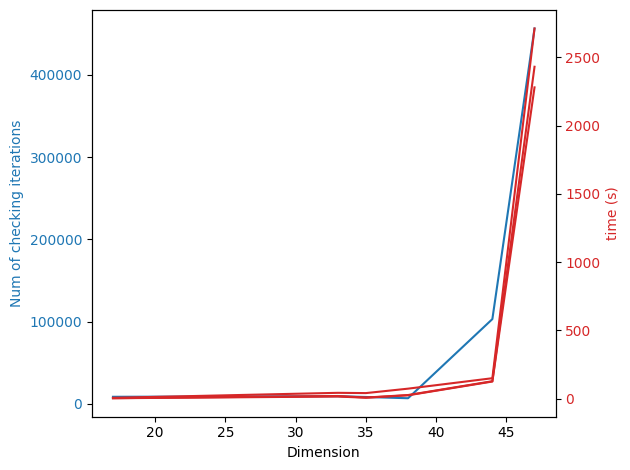

In [14]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Dimension')
ax1.set_ylabel('Num of checking iterations', color=color)
ax1.plot(df_bb['dimension'], df_bb['num_iterations'] - df_bb['last_iteration'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('time (s)', color=color)
ax2.plot(df_bb['dimension'][0:6], df_bb['time'][0:6], color=color)
ax2.plot(df_bb['dimension'][6:12], df_bb['time'][6:12], color=color)
ax2.plot(df_bb['dimension'][12:], df_bb['time'][12:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [16]:
path = "/content/exp1.csv"
df_exp = pd.read_csv(path)
df_exp2 = pd.read_csv('/content/exp2.csv')
df_exp3 = pd.read_csv('/content/exp3.csv')

In [38]:
df_exp['error'] = df_exp['cost'] - df_exp['true_cost']

In [41]:
df_exp2['norm_error'] = df_exp2['error'] / df_exp2['initial_cost'] * 100
df_exp3['norm_error'] = df_exp3['error'] / df_exp3['initial_cost'] * 100

In [30]:
df_comp1 = pd.read_csv('/content/exp5_compare_17_34.csv')
df_comp2 = pd.read_csv('/content/exp5_compare_remaining.csv')

In [38]:
df_comp = pd.concat([df_comp1, df_comp2])

Benchmark table 🔢

In [3]:
df_for_benchmark_table = pd.read_csv('/content/all_problems_fixed_parameters_whistory.csv')
df_for_benchmark_table.shape

(311, 12)

In [4]:
df_for_benchmark_table['norm_error'] = df_for_benchmark_table['error'] / df_for_benchmark_table['initial_cost'] * 100

In [11]:
df_for_benchmark_table['norm_error'].quantile(.3)

11.616438356164384

In [7]:
df_for_benchmark_table['var_norm_error'] = df_for_benchmark_table.groupby('dimension')['norm_error'].transform('var')
df_for_benchmark_table['mean_norm_error'] = df_for_benchmark_table.groupby('dimension')['norm_error'].transform('mean')

In [30]:
df_percentiles = df_for_benchmark_table.groupby('dimension')['norm_error'].quantile([0.25, 0.5, 0.75]).unstack().reset_index()

In [31]:
res = df_for_benchmark_table[['dimension', 'var_norm_error', 'mean_norm_error']].drop_duplicates('dimension').sort_values('dimension').reset_index().drop('index', axis=1)
pd.merge(res, df_percentiles, on='dimension')

,dimension,var_norm_error,mean_norm_error,0.25,0.5,0.75
0,34,2.986226,11.396721,9.639344,11.016393,13.442623
1,36,7.056806,17.611902,15.920651,17.980671,19.544761
2,39,13.097482,16.399309,15.140671,16.535044,18.447680
3,43,0.041357,0.905772,0.795376,0.921419,1.095271
4,45,0.000000,11.616438,11.616438,11.616438,11.616438
5,48,7.695274,14.775635,12.333736,13.780042,16.736842
6,53,0.551221,24.387939,23.757376,24.332433,24.914991
7,56,3.166527,21.150067,19.785619,20.388566,22.208575
8,65,0.384365,19.261874,18.656397,19.169876,19.726145
9,70,0.069645,9.595812,9.449680,9.579988,9.848749


In [24]:
df_33_greedy_whistory = pd.read_csv('/content/33_greedy_with_history.csv')
df_33_fixed_whistory = pd.read_csv('/content/33_fixed_parameters_whistory.csv')

Optimality curve ➰

In [25]:
df_33_fixed_whistory['norm_error'] = df_33_fixed_whistory['error'] / df_33_fixed_whistory['initial_cost'] * 100

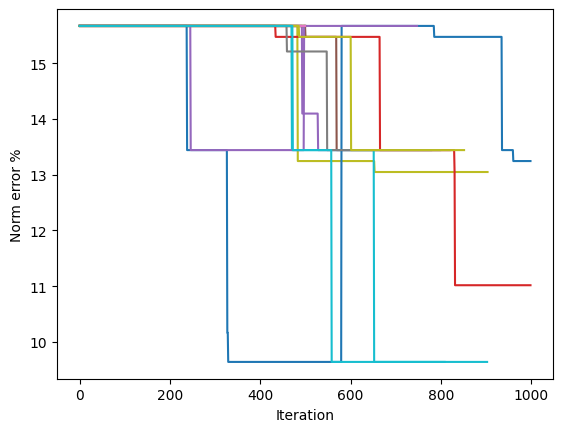

In [35]:
multiple_lists = []
for i in range(df_33_fixed_whistory.shape[0]):
  vals = [((v - df_33_fixed_whistory['true_cost'][i]) / df_33_fixed_whistory['initial_cost'][i]) * 100 for v in json.loads(df_33_fixed_whistory['gcost_iter'][i])]
  multiple_lists.append(vals)
  plt.plot(vals)
plt.xlabel('Iteration')
plt.ylabel('Norm error %')
plt.show()

In [39]:
# all runs are different lengths so pad with zeros to the longest sequence
# arrays = [np.array(x) for x in multiple_lists]
max_length = max(len(x) for x in multiple_lists)
fill = [0] * max_length
arrays = [np.array(sublist[:max_length] + fill[len(sublist):]) for sublist in multiple_lists]

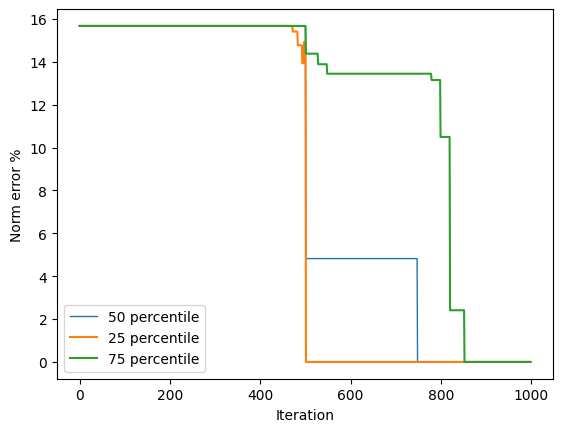

In [41]:
plt.plot([np.percentile(k, 50) for k in zip(*arrays)], label='50 percentile', linewidth=1)
plt.plot([np.percentile(k, 25) for k in zip(*arrays)], label='25 percentile')
plt.plot([np.percentile(k, 75) for k in zip(*arrays)], label='75 percentile')
plt.xlabel('Iteration')
plt.ylabel('Norm error %')
plt.legend()
plt.show()

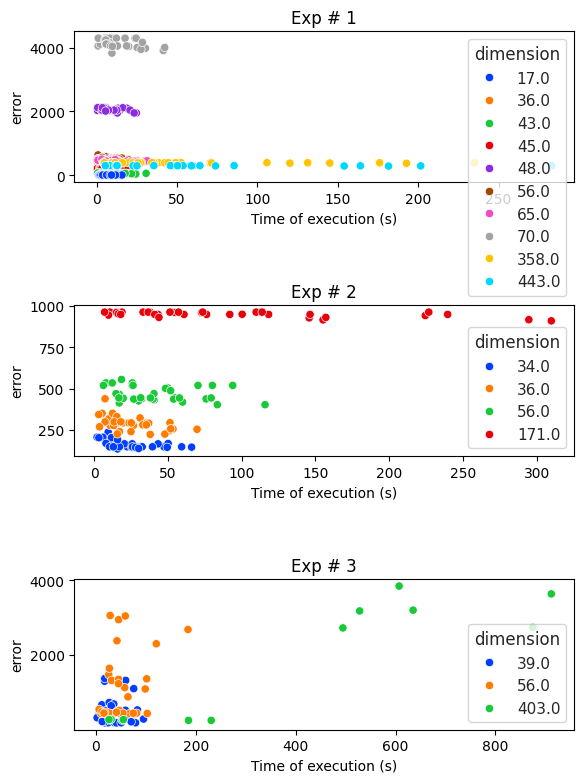

In [17]:
fig, ax = plt.subplots(3, figsize=(6, 8))
sns.set(style="ticks")
g1 = sns.scatterplot(
    data=df_exp,
    x='time',
    y="error",
    hue="dimension",
    palette=sns.color_palette('bright', df_exp.dimension.unique().shape[0]),
    ax = ax[0]
)
ax[0].set_title('Exp # 1')
ax[0].set_xlabel('Time of execution (s)')

g2 = sns.scatterplot(
    data=df_exp2,
    x='time',
    y="error",
    hue="dimension",
    palette=sns.color_palette('bright', df_exp2.dimension.unique().shape[0]),
    ax = ax[1]
)
ax[1].set_title('Exp # 2')
ax[1].set_xlabel('Time of execution (s)')

g3 = sns.scatterplot(
    data=df_exp3,
    x='time',
    y="error",
    hue="dimension",
    palette=sns.color_palette('bright', df_exp3.dimension.unique().shape[0]),
    ax = ax[2]
)
ax[2].set_title('Exp # 3')
ax[2].set_xlabel('Time of execution (s)')

plt.tight_layout()

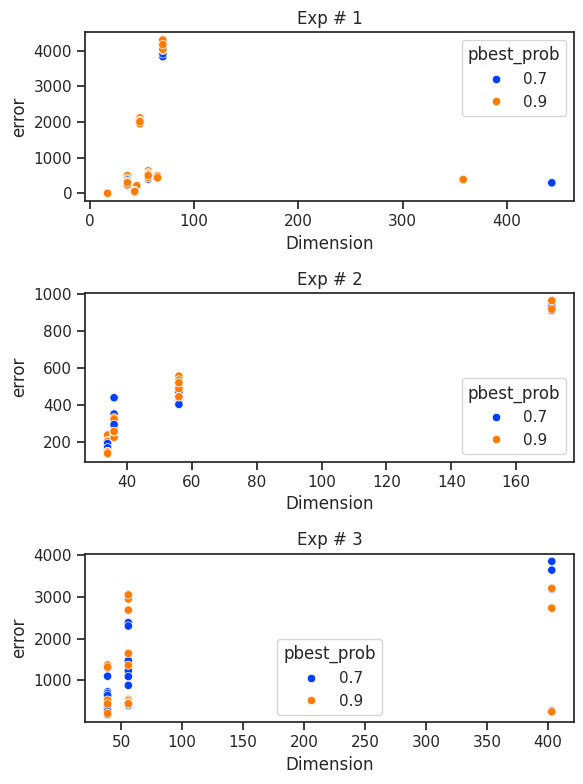

In [18]:
fig, ax = plt.subplots(3, figsize=(6, 8))
sns.set(style="ticks")
g1 = sns.scatterplot(
    data=df_exp,
    x='dimension',
    y="error",
    hue="pbest_prob",
    palette=sns.color_palette('bright', df_exp.pbest_prob.unique().shape[0]),
    ax = ax[0]
)
ax[0].set_title('Exp # 1')
ax[0].set_xlabel('Dimension')

g2 = sns.scatterplot(
    data=df_exp2,
    x='dimension',
    y="error",
    hue="pbest_prob",
    palette=sns.color_palette('bright', df_exp2.pbest_prob.unique().shape[0]),
    ax = ax[1]
)
ax[1].set_title('Exp # 2')
ax[1].set_xlabel('Dimension')

g3 = sns.scatterplot(
    data=df_exp3,
    x='dimension',
    y="error",
    hue="pbest_prob",
    palette=sns.color_palette('bright', df_exp3.pbest_prob.unique().shape[0]),
    ax = ax[2]
)
ax[2].set_title('Exp # 3')
ax[2].set_xlabel('Dimension')

plt.tight_layout()

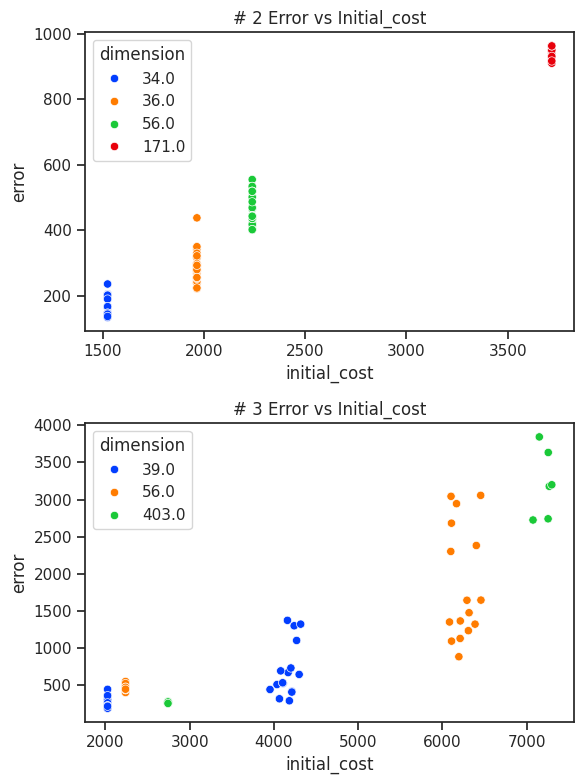

In [29]:
fig, ax = plt.subplots(2, figsize=(6, 8))
sns.set(style="ticks")

g1 = sns.scatterplot(
    data=df_exp2,
    x='initial_cost',
    y="error",
    hue="dimension",
    palette=sns.color_palette('bright', df_exp2.dimension.unique().shape[0]),
    ax=ax[0]
)
ax[0].set_title('# 2 Error vs Initial_cost')

g2 = sns.scatterplot(
    data=df_exp3,
    x='initial_cost',
    y="error",
    hue="dimension",
    palette=sns.color_palette('bright', df_exp3.dimension.unique().shape[0]),
    ax=ax[1]
)
ax[1].set_title('# 3 Error vs Initial_cost')

plt.tight_layout()

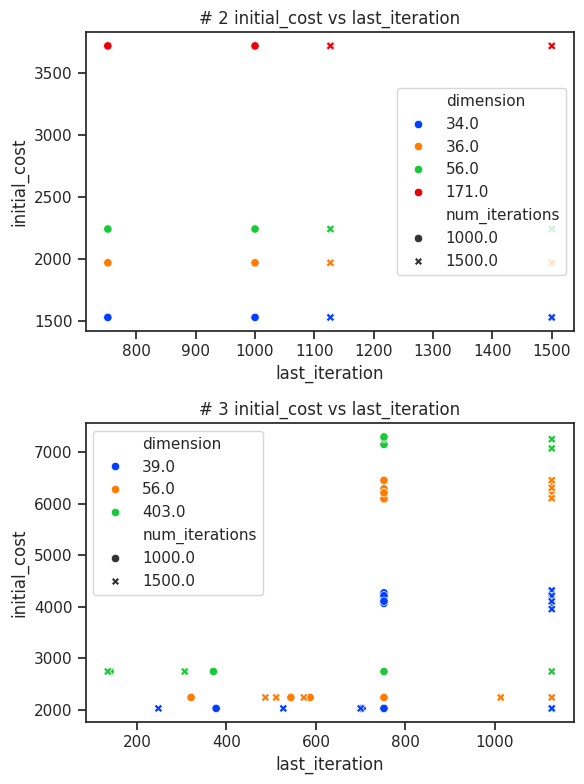

In [31]:
fig, ax = plt.subplots(2, figsize=(6, 8))
sns.set(style="ticks")

g1 = sns.scatterplot(
    data=df_exp2,
    x='last_iteration',
    y="initial_cost",
    hue="dimension",
    style='num_iterations',
    palette=sns.color_palette('bright', df_exp2.dimension.unique().shape[0]),
    ax=ax[0]
)
ax[0].set_title('# 2 initial_cost vs last_iteration')

g2 = sns.scatterplot(
    data=df_exp3,
    x='last_iteration',
    y="initial_cost",
    hue="dimension",
    style='num_iterations',
    palette=sns.color_palette('bright', df_exp3.dimension.unique().shape[0]),
    ax=ax[1]
)
ax[1].set_title('# 3 initial_cost vs last_iteration')

plt.tight_layout()

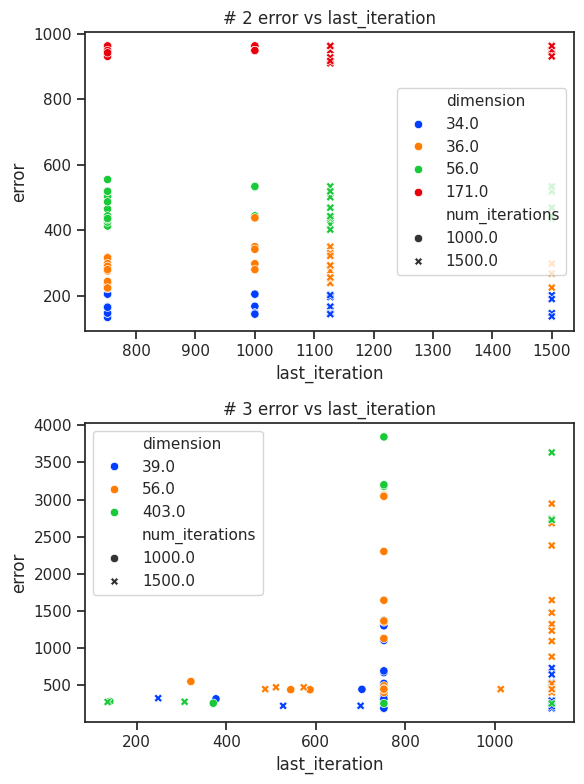

In [39]:
fig, ax = plt.subplots(2, figsize=(6, 8))
sns.set(style="ticks")

g1 = sns.scatterplot(
    data=df_exp2,
    x='last_iteration',
    y="error",
    hue="dimension",
    style="num_iterations",
    palette=sns.color_palette('bright', df_exp2.dimension.unique().shape[0]),
    ax=ax[0]
)
ax[0].set_title('# 2 error vs last_iteration')
ax[0].set_xlabel('last_iteration')

g2 = sns.scatterplot(
    data=df_exp3,
    x='last_iteration',
    y="error",
    hue="dimension",
    style="num_iterations",
    palette=sns.color_palette('bright', df_exp3.dimension.unique().shape[0]),
    ax=ax[1]
)
ax[1].set_title('# 3 error vs last_iteration')
ax[1].set_xlabel('last_iteration')

plt.tight_layout()

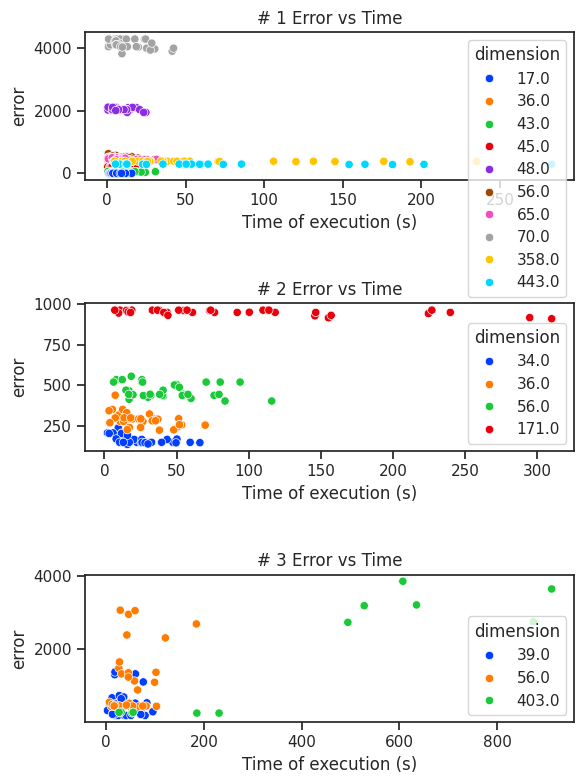

In [35]:
fig, ax = plt.subplots(3, figsize=(6, 8))
sns.set(style="ticks")

g1 = sns.scatterplot(
    data=df_exp,
    x='time',
    y="error",
    hue="dimension",
    palette=sns.color_palette('bright', df_exp.dimension.unique().shape[0]),
    ax=ax[0]
)
ax[0].set_title('# 1 Error vs Time')
ax[0].set_xlabel('Time of execution (s)')

g2 = sns.scatterplot(
    data=df_exp2,
    x='time',
    y="error",
    hue="dimension",
    palette=sns.color_palette('bright', df_exp2.dimension.unique().shape[0]),
    ax=ax[1]
)
ax[1].set_title('# 2 Error vs Time')
ax[1].set_xlabel('Time of execution (s)')

g3 = sns.scatterplot(
    data=df_exp3,
    x='time',
    y="error",
    hue="dimension",
    palette=sns.color_palette('bright', df_exp3.dimension.unique().shape[0]),
    ax=ax[2]
)
ax[2].set_title('# 3 Error vs Time')
ax[2].set_xlabel('Time of execution (s)')

plt.tight_layout()

<ipython-input-42-3901fe3826c6>:4: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  g1 = sns.scatterplot(
<ipython-input-42-3901fe3826c6>:16: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  g2 = sns.scatterplot(
<ipython-input-42-3901fe3826c6>:28: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  g3 = sns.scatterplot(


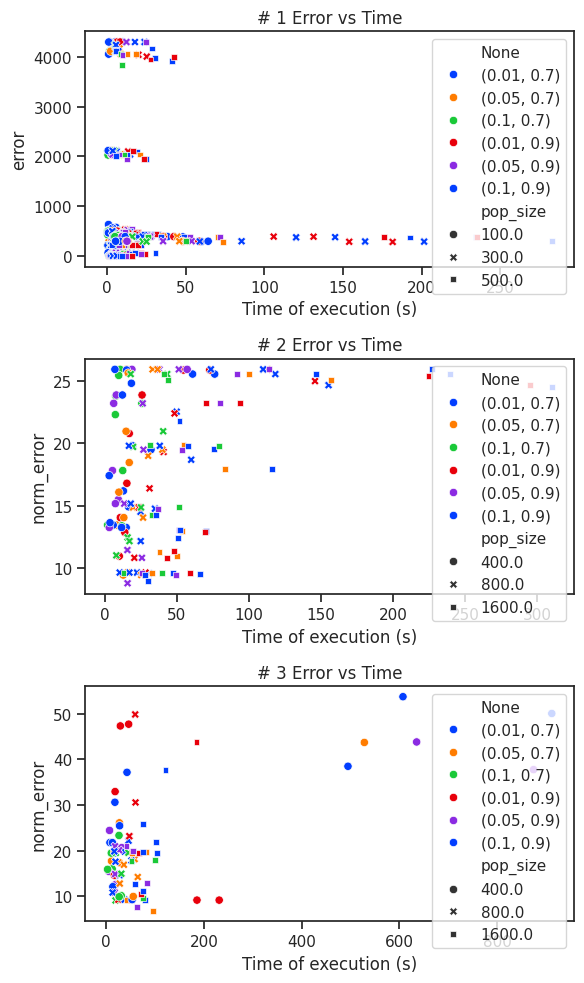

In [42]:
fig, ax = plt.subplots(3, figsize=(6, 10))
sns.set(style="ticks")

g1 = sns.scatterplot(
    data=df_exp,
    x='time',
    y="error",
    hue=df_exp[['gbest_prob', 'pbest_prob']].apply(tuple, axis=1),
    style="pop_size",
    palette=sns.color_palette('bright', df_exp[['gbest_prob', 'pbest_prob']].stack().unique().shape[0]),
    ax=ax[0]
)
ax[0].set_title('# 1 Error vs Time')
ax[0].set_xlabel('Time of execution (s)')

g2 = sns.scatterplot(
    data=df_exp2,
    x='time',
    y="norm_error",
    hue=df_exp2[['gbest_prob', 'pbest_prob']].apply(tuple, axis=1),
    style="pop_size",
    palette=sns.color_palette('bright', df_exp2[['gbest_prob', 'pbest_prob']].stack().unique().shape[0]),
    ax=ax[1]
)
ax[1].set_title('# 2 Error vs Time')
ax[1].set_xlabel('Time of execution (s)')

g3 = sns.scatterplot(
    data=df_exp3,
    x='time',
    y="norm_error",
    hue=df_exp3[['gbest_prob', 'pbest_prob']].apply(tuple, axis=1),
    style="pop_size",
    palette=sns.color_palette('bright', df_exp3[['gbest_prob', 'pbest_prob']].stack().unique().shape[0]),
    ax=ax[2]
)
ax[2].set_title('# 3 Error vs Time')
ax[2].set_xlabel('Time of execution (s)')

plt.tight_layout()

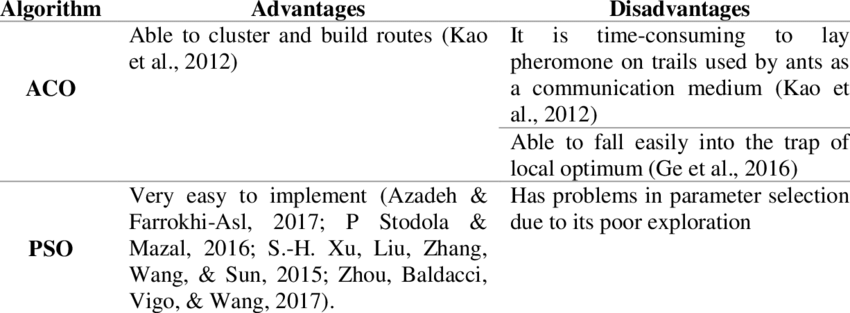

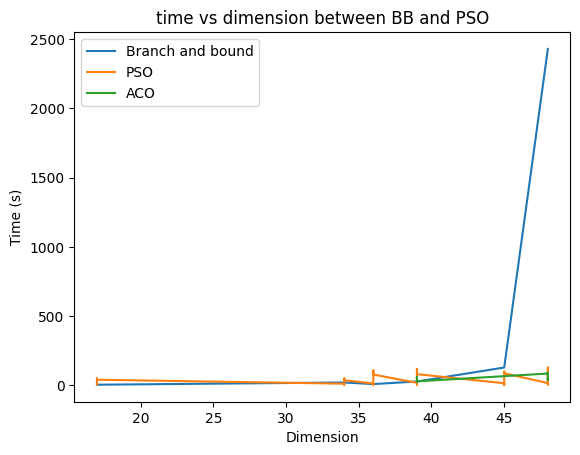

In [47]:
plt.plot(df_bb['dimension'][0:6], df_bb['time'][0:6], label="Branch and bound")
plt.plot(df_comp['dimension'], df_comp['time'], label="PSO")
plt.plot(aco.loc[aco['dimension'].isin(df_bb['dimension'].unique())]['dimension'], aco.loc[aco['dimension'].isin(df_bb['dimension'].unique())]['time'], label='ACO')
plt.xlabel('Dimension')
plt.ylabel('Time (s)')
plt.legend()
plt.title('time vs dimension between BB and PSO')
plt.show()

# Genetic Algorithm 🌍

In [ ]:
class GA:
  def __init__(self, num_iters, num_cities, distance_matrix, population_size, mutation_rate):
    self.population = []
    self.order = []
    self.num_cities = num_cities
    self.fitness = []
    self.distance_matrix = distance_matrix
    self.currentBest = []
    self.num_iters = num_iters
    self.population_size = population_size
    self.mutation_rate = mutation_rate
    self.bestEver = []
    self.recordDistance = np.inf
    self.currentRecord = np.inf

  def nextGeneration(self):
    newPopulation = []
    for i in range(len(self.population)):
      orderA = self.pickOne(self.population, self.fitness)
      orderB = self.pickOne(self.population, self.fitness)
      order = self.crossOver(orderA, orderB)
      order = self.mutate(order)
      newPopulation.append(order)
    self.population = newPopulation

  def mutate(self, order):
    for i in range(self.num_cities):
      if (random.random() < self.mutation_rate):
        indexA = random.randint(1, len(order) - 1)
        indexB = (indexA + 1) % n
        order[indexA], order[indexB] = order[indexB], order[indexA]
    return order

  def crossOver(self, orderA, orderB):
    start = random.randint(0, len(self.order) - 1)
    end = random.randint(start, len(self.order) - 1)
    newOrder = orderA[start:end+1]
    for i in range(len(orderB)):
      city = orderB[i]
      if (city not in newOrder): newOrder.append(city)
    return newOrder

  def pickOne(self, population, fitness):
    index = 0
    r = random.random()
    while (r > 0):
      r = r - fitness[index]
      index += 1
    index -= 1
    order3 = population[index]
    return order3

  def normalizeFitness(self):
    s = 0
    for i in range(len(self.fitness)):
      s += self.fitness[i]
    for i in range(len(self.fitness)):
      self.fitness[i] /= s

  def getTotalDistance(self, order):
    s = 0
    for i in range(len(order) - 1):
      s += self.distance_matrix[order[i]][order[i + 1]]
    return s

  def calculateFitness(self):
    for i in range(len(self.population)):
      d = self.getTotalDistance(self.population[i])
      if (d < self.recordDistance):
        self.recordDistance = d
        self.bestEver = self.population[i]
      if (d < self.currentRecord):
        self.currentRecord = d
        self.currentBest = self.population[i]

      self.fitness.append(1 / (d ** 5 + 1))

  def shuffle(self, order, num):
    order2 = []
    for i in range(len(order)): order2.append(order[i])

    for i in range(num):
      indexA = random.randint(0, len(order) - 1)
      indexB = random.randint(0, len(order) - 1)
      order2[indexA], order2[indexB] = order2[indexB], order2[indexA]

    return order2

  def run(self):
    for i in range(self.num_cities): self.order.append(i)

    for i in range(self.population_size):
      self.population.append(self.shuffle(self.order, self.num_cities))

    for i in range(self.num_iters):
      self.calculateFitness()
      self.normalizeFitness()
      self.nextGeneration()
      if i % 20 == 0:
        print(f'iter: {i} | record_cost: {self.recordDistance} | best: {self.bestEver}')

In [ ]:
# load test problem
n, c = read_atsplib('/content/sourcesAsymmetricTSP/ftv33.atsp')
adj = np.zeros((n, n))
for pair, distance in c.items():
  adj[pair[0] - 1][pair[1] - 1] = int(distance)
adj = adj.astype(int)

In [ ]:
ga = GA(1000, n, adj, 1000, 0.01)
ga.run()

iter: 0 | record_cost: 3306 | best: [6, 4, 26, 33, 1, 30, 21, 20, 16, 13, 9, 11, 12, 2, 32, 15, 24, 17, 7, 25, 8, 19, 22, 23, 31, 18, 10, 27, 28, 29, 3, 14, 5, 0]
iter: 20 | record_cost: 2863 | best: [11, 19, 26, 25, 2, 12, 0, 32, 7, 8, 9, 4, 6, 14, 15, 22, 31, 10, 17, 1, 30, 5, 18, 16, 13, 3, 24, 27, 28, 29, 23, 21, 20, 33]
iter: 40 | record_cost: 2863 | best: [11, 19, 26, 25, 2, 12, 0, 32, 7, 8, 9, 4, 6, 14, 15, 22, 31, 10, 17, 1, 30, 5, 18, 16, 13, 3, 24, 27, 28, 29, 23, 21, 20, 33]
iter: 60 | record_cost: 2863 | best: [11, 19, 26, 25, 2, 12, 0, 32, 7, 8, 9, 4, 6, 14, 15, 22, 31, 10, 17, 1, 30, 5, 18, 16, 13, 3, 24, 27, 28, 29, 23, 21, 20, 33]


KeyboardInterrupt: 

# Ant Colony Optimization Algorithm 🐜

In [ ]:
def run(space, iterations, colony, alpha, beta, del_tau, rho):
    # [1] Find inverted distances for all nodes
    inv_distances = inverseDistances(space)

    # Add beta algorithm parameter to inverted distances
    inv_distances = inv_distances ** beta

    # Empty pheromones trail
    pheromones = np.zeros((space.shape[0], space.shape[0]))

    # Empty minimum distance and path
    min_distance = None
    min_path = None

    # [2] For the number of iterations
    for i in range(iterations):
        # Initial random positions
        positions = initializeAnts(space, colony)

        # Complete a path
        paths = moveAnts(space, positions, inv_distances, pheromones, alpha, beta, del_tau)

        # Evaporate pheromones
        pheromones *= (1 - rho)

        # [3] For each path
        for path in paths:
            # Empty distance
            distance = 0

            # For each node from second to last
            for node in range(1, path.shape[0]):
                # Calculate distance to the last node
                distance += adj[path[node - 1]][path[node]]

            distance += adj[path[-1]][path[0]]

            # print(f'i={i} distance: {distance}')

            # Update minimun distance and path if less nor non existent
            if not min_distance or distance < min_distance:
                min_distance = distance
                min_path = path

        # Copy and append first node to end of minimum path to form closed path
        min_path = np.append(min_path, min_path[0])

    # Return tuple
    return (min_path, min_distance)

def inverseDistances(space):
    # Empty multidimensional array (matriz) to distances
    distances = copy.deepcopy(space)

    # Floating-point error handling - Setted to known state
    with np.errstate(all = 'ignore'):
        # Invert the distances
        inv_distances = 1 / distances

    # Replace infinity by zero to prevent zero division error
    inv_distances[inv_distances == np.inf] = 0

    # Eta algorithm result, inverted distances
    return inv_distances.astype(float)

def initializeAnts(space, colony):
    # Indexes of initial positions of ants
    return np.random.randint(space.shape[0], size = colony)

def moveAnts(space, positions, inv_distances, pheromones, alpha, beta, del_tau):
    # Empty multidimensional array (matriz) to paths
    paths = np.zeros((space.shape[0], positions.shape[0]), dtype = int) - 1

    # Initial position at node zero
    paths[0] = positions

    # For nodes after start to end
    for node in range(1, space.shape[0]):
        # For each ant
        for ant in range(positions.shape[0]):
            # Probability to travel the nodes
            next_location_probability = (inv_distances[positions[ant]] ** alpha + pheromones[positions[ant]] ** beta /
                                            inv_distances[positions[ant]].sum() ** alpha + pheromones[positions[ant]].sum() ** beta)

            # Index to maximum probability node
            next_position = np.argwhere(next_location_probability == np.amax(next_location_probability))[0][0]

            # Check if node has already been visited
            while next_position in paths[:, ant]:
                # Replace the probability of visited to zero
                next_location_probability[next_position] = 0.0

                # Find the maximum probability node
                next_position = np.argwhere(next_location_probability == np.amax(next_location_probability))[0][0]

            # Add node to path
            paths[node, ant] = next_position

            # Update pheromones (releasing pheromones)
            pheromones[node, next_position] = pheromones[node, next_position] + del_tau

    # Paths taken by the ants
    return np.swapaxes(paths, 0, 1)

In [ ]:
runs = {}
i = 0
iters = 20
# colony = 80
alpha = 1
beta = 1
for p in problem_files:
  if p.split('.')[0] in sols.keys():
    true_val = sols[p.split('.')[0]]
    # for alpha in [0.8, 1.6]:
        # for beta in [0.8, 1.6]:
    for colony in [80, 160]:
      for del_tau in [0.5, 1, 1.5]:
        for rho in [0.4, 0.8]:
          # prepare data
          n, c = read_atsplib(f'/content/sourcesAsymmetricTSP/{p}')
          adj = np.zeros((n, n))
          for pair, distance in c.items():
            if pair[0] == pair[1]: adj[pair[0] - 1][pair[1] - 1] = np.inf
            adj[pair[0] - 1][pair[1] - 1] = int(distance)
          s = time.time()
          path, d = run(adj, iters, colony, alpha, beta, del_tau, rho)
          e = time.time()
          runs[i] = {'d': d, 'true_d': true_val, 'dimension': n, 'num_iters': iters, 'colony_size': colony, 'alpha': alpha, 'beta': beta, 'del_tau': del_tau, 'rho': rho, 'time': round(e-s, 3)}
          print(f'i={i} dim: {n} d: {d} true_d: {true_val} colony: {colony} alpha: {alpha} beta: {beta} del_tau: {del_tau} rho: {rho} time: {(e-s):.3f} s')
          i += 1

i=0 dim: 39 d: 3674.0 true_d: 1530 colony: 80 alpha: 1 beta: 1 del_tau: 0.5 rho: 0.4 time: 28.310 s
i=1 dim: 39 d: 3762.0 true_d: 1530 colony: 80 alpha: 1 beta: 1 del_tau: 0.5 rho: 0.8 time: 27.017 s
i=2 dim: 39 d: 3695.0 true_d: 1530 colony: 80 alpha: 1 beta: 1 del_tau: 1 rho: 0.4 time: 28.859 s
i=3 dim: 39 d: 3695.0 true_d: 1530 colony: 80 alpha: 1 beta: 1 del_tau: 1 rho: 0.8 time: 27.456 s
i=4 dim: 39 d: 3680.0 true_d: 1530 colony: 80 alpha: 1 beta: 1 del_tau: 1.5 rho: 0.4 time: 28.797 s
i=5 dim: 39 d: 3528.0 true_d: 1530 colony: 80 alpha: 1 beta: 1 del_tau: 1.5 rho: 0.8 time: 27.416 s
i=6 dim: 39 d: 3667.0 true_d: 1530 colony: 160 alpha: 1 beta: 1 del_tau: 0.5 rho: 0.4 time: 56.747 s
i=7 dim: 39 d: 3584.0 true_d: 1530 colony: 160 alpha: 1 beta: 1 del_tau: 0.5 rho: 0.8 time: 55.187 s
i=8 dim: 39 d: 3672.0 true_d: 1530 colony: 160 alpha: 1 beta: 1 del_tau: 1 rho: 0.4 time: 56.989 s
i=9 dim: 39 d: 3639.0 true_d: 1530 colony: 160 alpha: 1 beta: 1 del_tau: 1 rho: 0.8 time: 54.714 s
i=10

KeyboardInterrupt: 

# ACO Analysis 📈

In [48]:
aco1 = pd.read_csv('/content/exp1ACO.csv')
aco2 = pd.read_csv('/content/exp2ACO.csv')
aco = pd.concat([aco1, aco2])

In [50]:
aco['error'] = aco['d'] - aco['true_d']

In [120]:
# greedy paths for each dimension in ACO
worst_case = {70: 42975, 48: 16540, 53: 9333, 171: 3718, 39: 2976, 56: 2239}

In [121]:
aco['worst_case'] = aco['dimension'].map(worst_case)

In [126]:
aco['norm_error'] = aco['error'] / aco['worst_case'] * 100

<ipython-input-130-b9e8e063ae9a>:1: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  g = sns.scatterplot(


Text(0.5, 1.0, 'error vs time')

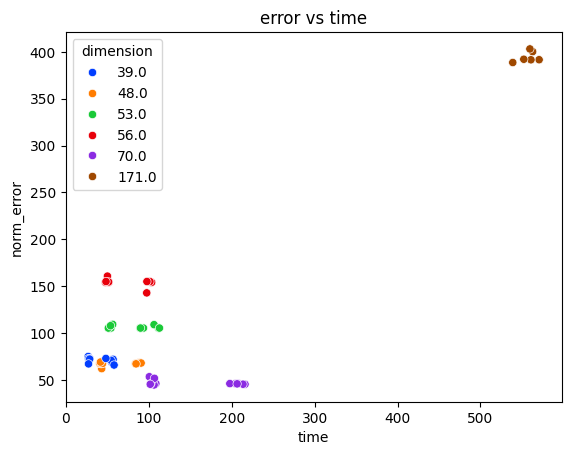

In [130]:
g = sns.scatterplot(
    data=aco,
    x='time',
    y="norm_error",
    hue="dimension",
    palette=sns.color_palette('bright', df_exp.dimension.unique().shape[0]),
)
g.set_title('error vs time')